In [20]:
import torch

def laplace(padded: torch.Tensor, dx: float) -> torch.Tensor:
    return (
        padded[..., :-2, 1:-1]  # above
        + padded[..., 1:-1, :-2]  # left
        - 4 * padded[..., 1:-1, 1:-1]  # center
        + padded[..., 1:-1, 2:]  # right
        + padded[..., 2:, 1:-1]  # below
    ) / dx**2

def periodic_laplace(arr: torch.Tensor, dx: float) -> torch.Tensor:
    pad_size = [1, 1]
    if arr.dim() > 2:
        pad_size = [(0, 0) for _ in range(arr.dim())]
        pad_size[-1] = (1, 1)
        pad_size[-2] = (1, 1)
    padded = torch.nn.functional.pad(arr, pad_size, mode='circular')
    return laplace(padded, dx)

def periodic_laplace_N(arr: torch.Tensor, dx: float, N: int) -> torch.Tensor:
    for _ in range(N):
        arr = periodic_laplace(arr, dx)
    return arr

def fourier_laplace(grid: torch.Tensor, dx: float, N: int = 1) -> torch.Tensor:
    frequencies = torch.fft.fft2(grid.to(torch.complex128))
    kx = torch.fft.fftfreq(grid.shape[-2], d=dx, device=grid.device)
    ky = torch.fft.fftfreq(grid.shape[-1], d=dx, device=grid.device)
    kx, ky = torch.meshgrid(kx, ky, indexing='ij')
    k_squared = kx**2 + ky**2
    fft_laplace = -((2 * torch.pi) ** 2) * k_squared
    result = torch.real(torch.fft.ifft2(frequencies * fft_laplace**N))
    return result / dx**2

def gradient(padded: torch.Tensor, dx: float, axis: int = 0) -> torch.Tensor:
    if axis == 0:
        return (padded[2:, 1:-1] - padded[:-2, 1:-1]) / (2 * dx)
    elif axis == 1:
        return (padded[1:-1, 2:] - padded[1:-1, :-2]) / (2 * dx)
    elif axis == -2:
        return (padded[..., 2:, 1:-1] - padded[..., :-2, 1:-1]) / (2 * dx)
    elif axis == -1:
        return (padded[..., 1:-1, 2:] - padded[..., 1:-1, :-2]) / (2 * dx)

def periodic_gradient(input_field: torch.Tensor, dx: float, axis: int = 0) -> torch.Tensor:
    pad_size = [1, 1]
    if axis < 0:
        pad_size = [(0, 0) for _ in range(input_field.dim())]
        pad_size[-1] = (1, 1)
        pad_size[-2] = (1, 1)
    padded = torch.nn.functional.pad(input_field, pad_size, mode='circular')
    return gradient(padded, dx, axis=axis)


In [40]:
import sys
import os
import h5py
import torch
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
from typing import Union, Tuple, Optional
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.models.dqfno import DQFNO
from src.losses.data_losses import LpLoss, H1Loss
from src.training.adamw import AdamW
from src.losses.finite_diff import laplacian_2d

torch.Size([64, 64])


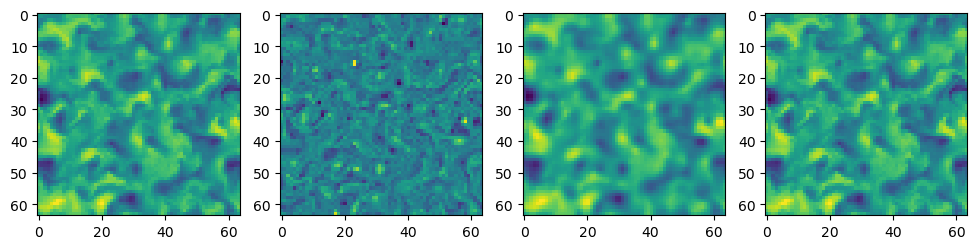

In [48]:
data_path = "/Users/anthonypoole/Data/TACC/hw2d_sim_step0.025_end1_pts512_c11_k015_N3_nu5e-8_20250205112740_25678_3.h5"
with h5py.File(data_path, 'r') as f:
    n = torch.from_numpy(f['density'][1600])
    o = torch.from_numpy(f['omega'][1600]) # Vorticity
    p = torch.from_numpy(f['phi'][1600])
    h = f.attrs['dx']
    lap_p = fourier_laplace(p, h*2102010,)
    print(lap_p.shape)
    # print(torch.isclose(o, lap_p).all())
    fig, ax = plt.subplots(1,4, figsize=(12,16))
    ax[0].imshow(n)
    ax[1].imshow(o)
    ax[2].imshow(p)
    ax[3].imshow(lap_p)
    plt.imshow(n)